# Bynary Classification

## Library & Dataset Import

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import joblib
from collections import Counter
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, precision_recall_curve, auc
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import wilcoxon, shapiro, ttest_rel
import warnings
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.w2v_feature_extraction import W2VTransformer
from utils.text_preprocessing import preprocess_text, TextPreprocessor
from utils.synonym_replacement import SynonymAugmenterToBalance


df_train = pd.read_csv("../dataset/training_set.csv")  
df_train = df_train[['text', 'binary_label']]
df_train = df_train[
    df_train['text'].notna() & df_train['text'].str.strip().astype(bool)
]
model1 = Word2Vec.load("../model/word2vec_model1.model")

X_text = df_train["text"].fillna("").astype(str)
y_binary = df_train["binary_label"].map({
    "cyberbullying": 1,
    "not_cyberbullying": 0
})

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## NestedLoop CrossValidation

In [ ]:
os.makedirs("../model/binary", exist_ok=True)
warnings.filterwarnings("ignore")


combinations = [
    ("BoW",   CountVectorizer(min_df=0.005)),
    ("TF-IDF", TfidfVectorizer(min_df=0.005)),
    ("W2V-1", W2VTransformer(model1))
]

param_grid = {
    "LogisticRegression": {
        "model__C": [0.01, 0.1, 1],
        "model__class_weight": ["balanced"]
    },
    "LinearSVM": {
        "model__C": [0.01, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [100, 500],
        "model__max_depth": [None, 20],
        "model__class_weight": ["balanced"],
        "model__random_state": [42]
    }
}

classifiers = [
    ("LogisticRegression", LogisticRegression(max_iter=1000), param_grid["LogisticRegression"]),
    ("RandomForest", RandomForestClassifier(), param_grid["RandomForest"]),
    ("LinearSVM", LinearSVC(max_iter=2000), param_grid["LinearSVM"])
]

scoring = ["f1_macro", "accuracy", "precision", "recall", "f1"]
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

nested_results = []

for vec_name, vectorizer in combinations:
    for clf_name, clf, grid_params in classifiers:
        print(f"\nNested CV — {vec_name} + {clf_name}")
        
        best_params_list = []
        all_fold_metrics = {m: [] for m in scoring}
        
        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_text, y_binary), 1):
            X_tr, X_te = X_text[train_idx], X_text[test_idx]
            y_tr, y_te = y_binary[train_idx], y_binary[test_idx]
            
            pipe = Pipeline([
                ("preprocessing", TextPreprocessor()),
                ('augment', SynonymAugmenterToBalance()),             
                ("vectorizer", vectorizer),           
                ("model", clf)
            ])

            grid = GridSearchCV(
                estimator=pipe,
                param_grid=grid_params,
                scoring=scoring,
                refit="f1_macro",
                cv=inner_cv,
                n_jobs=-1,
                verbose=0
            )
            grid.fit(X_tr, y_tr)
            
            best_params_list.append(grid.best_params_)
            
            y_pred = grid.predict(X_te)
            scores = {
                "accuracy":  np.mean(y_pred == y_te),
                "precision": precision_score(y_te, y_pred, zero_division=0),
                "recall":    recall_score(y_te, y_pred, zero_division=0),
                "f1":        f1_score(y_te, y_pred, zero_division=0),
                "f1_macro":  f1_score(y_te, y_pred, average="macro", zero_division=0)
            }
            for m, val in scores.items():
                all_fold_metrics[m].append(val)
            
            print(f"  Fold {fold}: best_params={grid.best_params_}")
        
        tuples = [tuple(sorted(d.items())) for d in best_params_list]
        most_common_tuple, count = Counter(tuples).most_common(1)[0]
        final_params = dict(most_common_tuple)
        print(f"Chosen params (mode over 10 folds): {final_params}")
        
        summary = {
            "Vectorizer": vec_name,
            "Classifier": clf_name,
            **{f"Mean {m}": np.mean(vals) for m, vals in all_fold_metrics.items()},
            **{f"Std {m}":   np.std(vals)  for m, vals in all_fold_metrics.items()}
        }
        nested_results.append(summary)
        
        final_pipe = Pipeline([
                ("preprocessing", TextPreprocessor()),
                ('augment', SynonymAugmenterToBalance()),             
                ("vectorizer", vectorizer),           
                ("model", clf)
            ])
        final_pipe.set_params(**final_params)
        final_pipe.fit(X_text, y_binary)
        
        filename = f"../model/binary/{clf_name}_{vec_name}.pkl"
        joblib.dump(final_pipe, filename)

nested_df = pd.DataFrame(nested_results)\
              .sort_values(by="Mean f1_macro", ascending=False)\
              .reset_index(drop=True)

print("=== Nested CV ===")
print(nested_df)
nested_df.to_csv("../model/binary/nested_cv_results.csv", index=False)


Nested CV — BoW + LogisticRegression


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 1: best_params={'model__C': 0.1, 'model__class_weight': 'balanced'}
  Fold 2: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 3: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 4: best_params={'model__C': 0.1, 'model__class_weight': 'balanced'}
  Fold 5: best_params={'model__C': 0.1, 'model__class_weight': 'balanced'}
  Fold 6: best_params={'model__C': 0.1, 'model__class_weight': 'balanced'}
  Fold 7: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 8: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 9: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 10: best_params={'model__C': 0.1, 'model__class_weight': 'balanced'}
Chosen params (mode over 10 folds): {'model__C': 0.1, 'model__class_weight': 'balanced'}

Nested CV — BoW + RandomForest
  Fold 1: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 100, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 2: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 100, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 3: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 4: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 5: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 6: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 7: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 8: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 9: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 10: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}
Chosen params (mode over 10 folds): {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}

Nested CV — BoW + LinearSVM


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 1: best_params={'model__C': 10}
  Fold 2: best_params={'model__C': 1}
  Fold 3: best_params={'model__C': 10}
  Fold 4: best_params={'model__C': 10}
  Fold 5: best_params={'model__C': 1}
  Fold 6: best_params={'model__C': 1}
  Fold 7: best_params={'model__C': 1}
  Fold 8: best_params={'model__C': 1}
  Fold 9: best_params={'model__C': 1}
  Fold 10: best_params={'model__C': 10}
Chosen params (mode over 10 folds): {'model__C': 1}

Nested CV — TF-IDF + LogisticRegression
  Fold 1: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 2: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 3: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 4: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 5: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 6: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 7: best_params={'model__C': 1, 'model__class_weight': 'balanced'}
  Fold 8: b

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 2: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 3: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
  Fold 4: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}
  Fold 5: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
  Fold 6: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


  Fold 7: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 100, 'model__random_state': 42}
  Fold 8: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 100, 'model__random_state': 42}
  Fold 9: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 100, 'model__random_state': 42}
  Fold 10: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
Chosen params (mode over 10 folds): {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}

Nested CV — TF-IDF + LinearSVM
  Fold 1: best_params={'model__C': 1}
  Fold 2: best_params={'model__C': 10}
  Fold 3: best_params={'model__C': 10}
  Fold 4: best_params={'model__C': 1}
  Fold 5: best_params={'model__C': 1}
  Fold 6: best_params={'model__C': 10}
  Fold 7: best_params={'mod

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 2: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 3: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 4: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 5: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 6: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 7: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 8: best_params={'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 9: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 10: best_params={'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 500, 'model__random_state': 42}
Chosen params (mode over 10 folds): {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 500, 'model__random_state': 42}

Nested CV — W2V-1 + LinearSVM


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

  Fold 1: best_params={'model__C': 0.01}
  Fold 2: best_params={'model__C': 0.01}
  Fold 3: best_params={'model__C': 0.01}
  Fold 4: best_params={'model__C': 0.01}
  Fold 5: best_params={'model__C': 0.01}
  Fold 6: best_params={'model__C': 0.01}
  Fold 7: best_params={'model__C': 0.01}
  Fold 8: best_params={'model__C': 0.01}
  Fold 9: best_params={'model__C': 0.01}
  Fold 10: best_params={'model__C': 0.01}
Chosen params (mode over 10 folds): {'model__C': 0.01}
=== Nested CV ===
  Vectorizer          Classifier  Mean f1_macro  Mean accuracy  \
0     TF-IDF  LogisticRegression       0.720981       0.794931   
1        BoW  LogisticRegression       0.719513       0.789034   
2     TF-IDF           LinearSVM       0.718948       0.791078   
3     TF-IDF        RandomForest       0.717019       0.794695   
4        BoW        RandomForest       0.716926       0.777737   
5        BoW           LinearSVM       0.716482       0.783792   
6      W2V-1        RandomForest       0.695382       

## Model Selection

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)

y = y_binary

results = pd.read_csv("../model/binary/nested_cv_results.csv")

results_sorted = results.head(9)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scorer_f1macro = make_scorer(f1_score, average="macro")

scores_dict = {}

for _, row in results_sorted.iterrows():
    vec_name = row["Vectorizer"]
    clf_name = row["Classifier"]

    print(f"Evaluating {clf_name} + {vec_name}")

    model_path = f"../model/binary/{clf_name}_{vec_name}.pkl"
    pipeline = joblib.load(model_path)

    accuracy_scores = cross_val_score(
        pipeline, X_text, y, cv=cv, scoring=scorer_f1macro, n_jobs=-1
    )
    key = f"{clf_name} + {vec_name}"
    scores_dict[key] = accuracy_scores

scores_df = pd.DataFrame(scores_dict)
scores_df.to_csv("../model/binary/repeated_cv_scores.csv", index=False)

display(scores_df.describe())

Evaluating LogisticRegression + TF-IDF
Evaluating LogisticRegression + BoW
Evaluating LinearSVM + TF-IDF
Evaluating RandomForest + TF-IDF
Evaluating RandomForest + BoW


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils.

Evaluating LinearSVM + BoW
Evaluating RandomForest + W2V-1
Evaluating LogisticRegression + W2V-1


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Evaluating LinearSVM + W2V-1


,LogisticRegression + TF-IDF,LogisticRegression + BoW,LinearSVM + TF-IDF,RandomForest + TF-IDF,RandomForest + BoW,LinearSVM + BoW,RandomForest + W2V-1,LogisticRegression + W2V-1,LinearSVM + W2V-1
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.720889,0.720083,0.718743,0.714985,0.716999,0.716872,0.694299,0.684811,0.684449
std,0.006635,0.007069,0.006777,0.008213,0.007442,0.007169,0.008070,0.006048,0.005607
min,0.706511,0.705754,0.702535,0.700705,0.703898,0.701925,0.675629,0.671007,0.671342
25%,0.717314,0.715729,0.715356,0.707959,0.711640,0.712977,0.690944,0.680482,0.681629
50%,0.721243,0.719619,0.719169,0.715210,0.716996,0.716849,0.693166,0.683358,0.684494
75%,0.725226,0.724523,0.722342,0.718775,0.722570,0.722069,0.698852,0.690015,0.688105
max,0.735628,0.735788,0.733700,0.734098,0.729914,0.733700,0.712671,0.695830,0.695676


In [4]:
scores_df = pd.read_csv("../model/binary/repeated_cv_scores.csv")
results = pd.DataFrame(results)\
              .sort_values(by="Mean f1_macro", ascending=False)\
              .reset_index(drop=True)

model_names = list(scores_df.columns)
N = len(model_names)
matrix = pd.DataFrame(0, index=model_names, columns=model_names)

for i in range(N):
    name_i = model_names[i]
    for j in range(i+1, N):
        name_j = model_names[j]
        diffs = scores_df[name_i] - scores_df[name_j]
        stat_norm, p_norm = shapiro(diffs)
        if p_norm > 0.05:
            stat_test, p_test = ttest_rel(
                scores_df[name_i], scores_df[name_j]
            )
        else:
            stat_test, p_test = wilcoxon(
                scores_df[name_i], scores_df[name_j]
            )
        if p_test < 0.05 :
            if scores_df[name_i].mean() > scores_df[name_j].mean():
                matrix.loc[name_i, name_j] = 1
                matrix.loc[name_j, name_i] = -1
            elif scores_df[name_i].mean() < scores_df[name_j].mean():
                matrix.loc[name_i, name_j] = -1
                matrix.loc[name_j, name_i] = 1

print("\nPairwise victory matrix (1 = win, 0 = no win, -1 = defeat):")
display(matrix)

wins = matrix.sum(axis=1)
print("\nNumber of victories per model:")
display(wins)

max_wins = wins.max()
winners = wins[wins == max_wins].index.tolist()
print(f"\nWinner(s) with {max_wins} victories: {', '.join(winners)}")

for winner in winners:
    print(f"\nHead-to-head details for {winner}:")
    for opponent in model_names:
        if opponent == winner:
            continue
        diffs = scores_df[winner] - scores_df[opponent]
        stat_norm, p_norm = shapiro(diffs)
        if p_norm > 0.05:
            stat_test, p_test = ttest_rel(
                scores_df[winner], scores_df[opponent]
            )
            test_name = 't-test'
        else:
            stat_test, p_test = wilcoxon(
                scores_df[winner], scores_df[opponent]
            )
            test_name = 'Wilcoxon'
        result = 'win' if matrix.loc[winner, opponent] == 1 else 'no win'
        print(
            f"{winner} vs {opponent}: {test_name}, "
            f"stat={stat_test:.4f}, p={p_test:.4f} -> {result}"
        )



Pairwise victory matrix (1 = win, 0 = no win, -1 = defeat):


,LogisticRegression + TF-IDF,LogisticRegression + BoW,LinearSVM + TF-IDF,RandomForest + TF-IDF,RandomForest + BoW,LinearSVM + BoW,RandomForest + W2V-1,LogisticRegression + W2V-1,LinearSVM + W2V-1
LogisticRegression + TF-IDF,0,0,1,1,1,1,1,1,1
LogisticRegression + BoW,0,0,0,1,1,1,1,1,1
LinearSVM + TF-IDF,-1,0,0,1,0,1,1,1,1
RandomForest + TF-IDF,-1,-1,-1,0,0,0,1,1,1
RandomForest + BoW,-1,-1,0,0,0,0,1,1,1
LinearSVM + BoW,-1,-1,-1,0,0,0,1,1,1
RandomForest + W2V-1,-1,-1,-1,-1,-1,-1,0,1,1
LogisticRegression + W2V-1,-1,-1,-1,-1,-1,-1,-1,0,0
LinearSVM + W2V-1,-1,-1,-1,-1,-1,-1,-1,0,0



Number of victories per model:


LogisticRegression + TF-IDF    7
LogisticRegression + BoW       6
LinearSVM + TF-IDF             4
RandomForest + TF-IDF          0
RandomForest + BoW             1
LinearSVM + BoW                0
RandomForest + W2V-1          -4
LogisticRegression + W2V-1    -7
LinearSVM + W2V-1             -7
dtype: int64


Winner(s) with 7 victories: LogisticRegression + TF-IDF

Head-to-head details for LogisticRegression + TF-IDF:
LogisticRegression + TF-IDF vs LogisticRegression + BoW: t-test, stat=1.1996, p=0.2400 -> no win
LogisticRegression + TF-IDF vs LinearSVM + TF-IDF: t-test, stat=5.0819, p=0.0000 -> win
LogisticRegression + TF-IDF vs RandomForest + TF-IDF: t-test, stat=4.8459, p=0.0000 -> win
LogisticRegression + TF-IDF vs RandomForest + BoW: t-test, stat=4.3343, p=0.0002 -> win
LogisticRegression + TF-IDF vs LinearSVM + BoW: Wilcoxon, stat=41.0000, p=0.0000 -> win
LogisticRegression + TF-IDF vs RandomForest + W2V-1: t-test, stat=14.3173, p=0.0000 -> win
LogisticRegression + TF-IDF vs LogisticRegression + W2V-1: t-test, stat=22.2658, p=0.0000 -> win
LogisticRegression + TF-IDF vs LinearSVM + W2V-1: t-test, stat=25.4619, p=0.0000 -> win


## Comparison of two best performing model on secondary metrics

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)

y = y_binary

results = pd.read_csv("../model/binary/nested_cv_results.csv")

results_sorted = results.head(2)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

scoring = ["accuracy", "precision", "recall", "f1"]

scores_dict = {}

for _, row in results_sorted.iterrows():
    vec_name = row["Vectorizer"]
    clf_name = row["Classifier"]
    
    print(f"Evaluating {clf_name} + {vec_name}")
    
    model_path = f"../model/binary/{clf_name}_{vec_name}.pkl"
    pipeline = joblib.load(model_path)

    results_cv = cross_validate(
        pipeline, X_text, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    key = f"{clf_name} + {vec_name}"
    for metric in scoring:
        scores_dict[f"{key} - {metric}"] = results_cv[f"test_{metric}"]

scores_df = pd.DataFrame(scores_dict)
scores_df.to_csv("../model/binary/repeated_cv_scores_second_comparison.csv", index=False)

display(scores_df.describe())

Evaluating LogisticRegression + TF-IDF
Evaluating LogisticRegression + BoW


,LogisticRegression + TF-IDF - accuracy,LogisticRegression + TF-IDF - precision,LogisticRegression + TF-IDF - recall,LogisticRegression + TF-IDF - f1,LogisticRegression + BoW - accuracy,LogisticRegression + BoW - precision,LogisticRegression + BoW - recall,LogisticRegression + BoW - f1
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.794844,0.961004,0.785724,0.864548,0.788929,0.969608,0.770901,0.858892
std,0.006450,0.002688,0.007772,0.004796,0.006876,0.002429,0.007828,0.005150
min,0.782176,0.955444,0.769110,0.854746,0.774574,0.964258,0.754954,0.848057
25%,0.791691,0.959332,0.782137,0.862530,0.784876,0.968007,0.767083,0.855776
50%,0.794495,0.960803,0.785849,0.864215,0.788598,0.969971,0.770090,0.858572
75%,0.798165,0.963376,0.788522,0.866854,0.792963,0.970943,0.774843,0.862078
max,0.808650,0.965611,0.804717,0.874570,0.805242,0.973757,0.790566,0.871253


In [6]:
import pandas as pd
from scipy.stats import shapiro, ttest_rel, wilcoxon

df = pd.read_csv("../model/binary/repeated_cv_scores_second_comparison.csv")

model_names = list(set(col.split(" - ")[0] for col in df.columns))
metrics = list(set(col.split(" - ")[1] for col in df.columns))

model_names.sort()
metrics.sort()

results_summary = []
comparison_summary = {"Model 1 Wins": 0, "Model 2 Wins": 0, "Ties": 0}

for metric in metrics:
    col1 = f"{model_names[0]} - {metric}"
    col2 = f"{model_names[1]} - {metric}"
    
    diff = df[col1] - df[col2]
    
    stat, p_normality = shapiro(diff)
    if p_normality > 0.05:
        test_stat, p_value = ttest_rel(df[col1], df[col2])
    else:
        test_stat, p_value = wilcoxon(df[col1], df[col2])

    if p_value > 0.05:
        result = "Tie"
        comparison_summary["Ties"] += 1
    else:
        if diff.mean() > 0:
            result = f"{model_names[0]} Wins"
            comparison_summary[f"{model_names[0]}"] = comparison_summary.get(f"{model_names[0]}", 0) + 1
        else:
            result = f"{model_names[1]} Wins"
            comparison_summary[f"{model_names[1]}"] = comparison_summary.get(f"{model_names[1]}", 0) + 1

    results_summary.append({
        "Metric": metric,
        f"{model_names[0]}": df[col1].mean(),
        f"{model_names[1]}": df[col2].mean(),
        "p-value": p_value,
        "Test Used": "t-test" if p_normality > 0.05 else "Wilcoxon",
        "Result": result
    })

results_df = pd.DataFrame(results_summary)

comparison_df = pd.DataFrame([comparison_summary])

print("Best model per metrics:")
display(results_df)

print("Resuming:")
display(comparison_df)


Best model per metrics:


,Metric,LogisticRegression + BoW,LogisticRegression + TF-IDF,p-value,Test Used,Result
0,accuracy,0.788929,0.794844,2.223134e-11,t-test,LogisticRegression + TF-IDF Wins
1,f1,0.858892,0.864548,2.119370e-14,t-test,LogisticRegression + TF-IDF Wins
2,precision,0.969608,0.961004,2.791299e-19,t-test,LogisticRegression + BoW Wins
3,recall,0.770901,0.785724,4.911475e-21,t-test,LogisticRegression + TF-IDF Wins


Resuming:


,Model 1 Wins,Model 2 Wins,Ties,LogisticRegression + TF-IDF,LogisticRegression + BoW
0,0,0,0,3,1


## Test set test


--- LogisticRegression + TF-IDF ---
Accuracy:             0.7964
Balanced Accuracy:    0.8202
Precision:            0.9646
Recall (Sensitivity): 0.7845
Specificity:          0.8559
F1 Score:             0.8653
F1 Score macro:       0.7244
AUC-ROC:              0.8871
PR-AUC:               0.9767


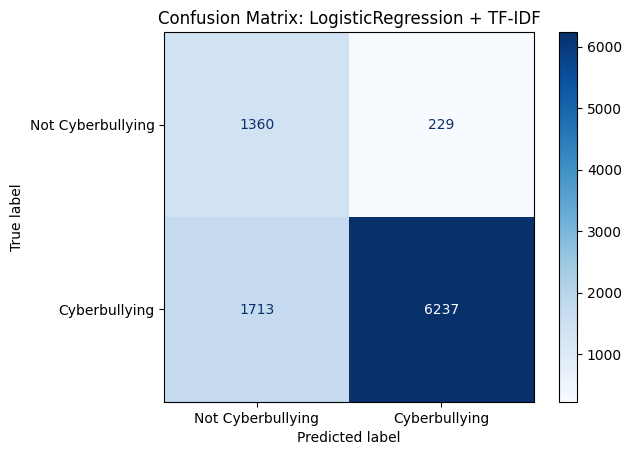

In [7]:
df_eval_sorted = pd.read_csv("../model/binary/nested_cv_results.csv")
df_eval_sorted = pd.DataFrame(df_eval_sorted)\
              .sort_values(by="Mean f1_macro", ascending=False)\
              .reset_index(drop=True)
df_test = pd.read_csv("../dataset/test_set.csv")
X_test_text = df_test["text"]
y_test = df_test["binary_label"].map({"cyberbullying": 1, "not_cyberbullying": 0}).values

def print_metrics_and_confmat(y_true, y_pred, y_proba, title):
    print(f"\n--- {title} ---")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    spec = recall_score(y_true, y_pred, pos_label=0)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall_curve, precision_curve)

    print(f"Accuracy:             {acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Precision:            {prec:.4f}")
    print(f"Recall (Sensitivity): {rec:.4f}")
    print(f"Specificity:          {spec:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"F1 Score macro:       {f1_macro:.4f}")
    print(f"AUC-ROC:              {auc_roc:.4f}")
    print(f"PR-AUC:               {pr_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Cyberbullying", "Cyberbullying"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()


top_model = df_eval_sorted.head(1).tail(1)
predictions = []


model_name = top_model["Classifier"].iloc[0]
vectorizer_name = top_model["Vectorizer"].iloc[0]
    
file_name = f"../model/binary/{model_name}_{vectorizer_name}.pkl"
clf = joblib.load(file_name)

   
y_pred = clf.predict(X_test_text)
y_proba = (
    clf.predict_proba(X_test_text)[:, 1]
    if hasattr(clf.named_steps["model"], "predict_proba")
    else y_pred
)
    
predictions.append(y_pred)
    
print_metrics_and_confmat(y_test, y_pred, y_proba, f"{model_name} + {vectorizer_name}")